# Customer Churn

This is a short demonstration on how to create and use a custom Weibull survival neural network model to predict customer churn. I use a similar example in my master's thesis on parametric survival neural networks. This is a survival analysis because we are interested in the time in months until a customer no longer uses the services of a business.

## Background

Prior literature merges the Cox proportional hazards model with neural networks by replacing the risk function with the output of a neural network. The idea is that the neural network will learn complex relationships (non-linearities and interaction terms) between the response and features better than a traditional model. This can be extended to parametric models, which I demonstrate with the Weibull model. The Weibull hazard function, survival function, and pdf are

\begin{equation}
\begin{aligned}
h(t) &= \lambda p t^{p-1}, \\ S(t) &= \exp(-\lambda t^p), \\ f(t) &= h(t)S(t) = \lambda p t^{p-1} \exp(-\lambda t^p).
\end{aligned}
\end{equation}

Traditionally, the Weibull survival model is expressed as a proportional hazards model through the reparameterization of $\lambda$ as $\exp[r(X, \beta)]$, where $r(X, \beta)$ is typically assumed to be a linear risk function, i.e. $X'\beta$. In the neural network model, the risk function, $r(X, \beta)$, will be replaced by the output of the neural network, $g(X,\theta)$, where $\theta$ is the vector of inputs, weights, biases, and shape parameter, $p$, of the neural network. The parameters of the model ($p,\beta_0, \beta_1,...$) are estimated by maximizing the parametric likelihood which is the product of each individual's contribution to the likelihood. The likelihood is

\begin{equation*}
L(\theta) = \prod_{i=1}^{N} f(T_i,x_i)^{\delta_i}S(T_i,x_i)^{1-\delta_i}
\end{equation*}

where $t_i$ is event time, $x_i$ is the individual vector of covariates, and $\delta_i$ is the event indicator.

The likelihood for the Weibull neural network model is

\begin{equation*}
L(\theta) = \prod_{i=1}^{N} \left(\exp[g(x_i, \theta)] p t_i^{p-1} \exp(-\exp[g(x_i, \theta)] t_i^p)\right)^{\delta_i} \left(\exp(-\exp[g(x_i, \theta)] t_i^p)\right)^{1-\delta_i}
\end{equation*}

where $g(x_i, \theta)$ is the output of the neural network.

Instead of maximizing the log-likelihood function to estimate the parameters, we will minimize the negative log-likelihood as the loss function to update the parameters.

## Import Modules and Load Data

The data is imported from Pysurvival. I don't directly import the data from the Pysurvival model because I cannot install Pysurvival on Windows.

In [73]:
# import modules
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from numpy import trapz
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from itertools import groupby
from itertools import combinations
from torch import linalg as LA
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# import raw data (originally from Pysurvival)
raw = pd.read_csv("..\data\churn.csv")

## Data cleaning

I will creat one-hot-vecors for the categorical variables, check for null or duplicate values, scale the numeric variables, and split the data into training and testing sets. The "product_data_storage" column shown below is a numeric column with a greater scale than the other numeric variables. To put all of them on the same scale I standardize based on the training mean and standard deviation.

In [18]:
# display data
raw.head(3)

,product_data_storage,product_travel_expense,product_payroll,product_accounting,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,company_size,us_region,months_active,churned
0,2048,Free-Trial,Active,No,9,4,0,14,1,8.3,10-50,West North Central,3.0,1.0
1,2048,Free-Trial,Free-Trial,Active,9,4,2,12,1,0.0,100-250,South Atlantic,2.0,1.0
2,2048,Active,Active,Active,9,3,2,17,1,0.0,100-250,East South Central,7.0,0.0


In [19]:
# creating one-hot vectors
categories = ['product_travel_expense', 'product_payroll', 'product_accounting',
              'us_region', 'company_size']
dataset = pd.get_dummies(raw, columns=categories, drop_first=True)

# creating the time and event columns
time_column = 'months_active'
event_column = 'churned'

# extracting the features
features = np.setdiff1d(dataset.columns, [time_column, event_column] ).tolist()

In [20]:
# checking for null values
N_null = sum(dataset[features].isnull().sum())
print("The raw_dataset contains {} null values".format(N_null))

# removing duplicates if there exist
N_dupli = sum(dataset.duplicated(keep='first'))
dataset = dataset.drop_duplicates(keep='first').reset_index(drop=True)
print("The raw_dataset contains {} duplicates".format(N_dupli))

# number of samples in the dataset
N = dataset.shape[0]

The raw_dataset contains 0 null values
The raw_dataset contains 0 duplicates


In [21]:
# building training and testing sets
index_train, index_test = train_test_split( range(N), test_size = 0.3, random_state=2)
data_train = dataset.loc[index_train].reset_index( drop = True )
data_test  = dataset.loc[index_test].reset_index( drop = True )

# standardize
conts = ['product_data_storage', 'csat_score', 'articles_viewed',
       'smartphone_notifications_viewed', 'marketing_emails_clicked',
       'social_media_ads_viewed', 'minutes_customer_support']
for col in conts:
  scaler = StandardScaler()
  data_train[col] = scaler.fit_transform(data_train[col].values.reshape(-1,1))
  data_test[col] = scaler.transform(data_test[col].values.reshape(-1,1))

## Neural Network Model

I will use pytorch to fit a Weibull neural network model. 

In [22]:
X = ['product_data_storage', 'csat_score', 'articles_viewed',
       'smartphone_notifications_viewed', 'marketing_emails_clicked',
       'social_media_ads_viewed', 'minutes_customer_support',
       'product_travel_expense_Free-Trial',
       'product_travel_expense_No', 'product_payroll_Free-Trial',
       'product_payroll_No', 'product_accounting_Free-Trial',
       'product_accounting_No', 'us_region_East South Central',
       'us_region_Middle Atlantic', 'us_region_Mountain',
       'us_region_New England', 'us_region_Pacific',
       'us_region_South Atlantic', 'us_region_West North Central',
       'us_region_West South Central', 'company_size_10-50',
       'company_size_100-250', 'company_size_50-100',
       'company_size_self-employed']
time = ['months_active']
status = ['churned']

In [23]:
# training tensors
X_cols_train = np.stack([data_train[col].values for col in X], axis = 1)
XTensor_train = torch.tensor(X_cols_train, dtype = torch.float)
timeTensor_train = torch.tensor(data_train[time].values, dtype = torch.float)
statusTensor_train = torch.tensor(data_train[status].values, dtype = torch.float)

# testing tensors
X_cols_test = np.stack([data_test[col].values for col in X], axis = 1)
XTensor_test = torch.tensor(X_cols_test, dtype = torch.float)
timeTensor_test = torch.tensor(data_test[time].values, dtype = torch.float)
statusTensor_test = torch.tensor(data_test[status].values, dtype = torch.float)

In [24]:
# neural network class

class WeibullNNModel(nn.Module):

    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.sequential = nn.Sequential(
            nn.Linear(self.input_size, 25),
            nn.ReLU(),
            nn.Linear(25, 5),
            nn.ReLU(),
            nn.Linear(5, 1)
        )
        self.parallel = nn.Sequential(
            nn.Linear(1, 1),
            nn.Softplus(),
        )
    
    def forward(self, x):
        x = self.sequential(x)
        p = self.parallel(torch.ones(x.shape))
        return torch.cat((x, p), 1)

In [25]:
# define weibull log likelihood

def weibullLogL(output, p, fail_status, time, model_parameters, penalty_lambda=0):
    '''
    output = output from model (tensor)
    p = shape parameter of weibull 
    fail_status = 1 if event, 0 if censor (tensor)
    time = event time in ascending order (tensor)
    penalty_lambda = weight of penalty
    '''
    lamb = torch.exp(output)
    value_list = []
    for index, value in enumerate(fail_status):
      if value == 1:
        event = torch.log(lamb[index])+torch.log(p[index])+((p[index]-1)*torch.log(time[index]))-(lamb[index]*torch.pow(time[index], p[index]))
        value_list.append(event)
      else:
        censor = -1*lamb[index]*torch.pow(time[index], p[index])
        value_list.append(censor)
    value_list = torch.stack(value_list)
    #n = len(fail_status)
    L = -1*torch.sum(value_list)
    # penalty
    param_tensor = torch.nn.utils.parameters_to_vector(model_parameters)
    param_tensor =  torch.matmul(param_tensor,param_tensor)
    penalty = penalty_lambda*param_tensor
    L = L + penalty
    return L

In [26]:
# instance
torch.manual_seed(3)
model = WeibullNNModel(len(X))

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [27]:
# train network

epochs = 200
losses = []

for i in range(epochs):
    i+=1
    risk = model(XTensor_train)
    loss = weibullLogL(output = risk[:, 0], p = risk[:, 1], 
                       fail_status = statusTensor_train, time = timeTensor_train,
                       model_parameters=model.parameters(), penalty_lambda=1)
    losses.append(loss)
    
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

epoch:   1  loss: 2888.86499023
epoch:  26  loss: 2071.54980469
epoch:  51  loss: 1704.60522461
epoch:  76  loss: 1463.63000488
epoch: 101  loss: 1309.77551270
epoch: 126  loss: 1203.57934570
epoch: 151  loss: 1127.44885254
epoch: 176  loss: 1070.80468750
epoch: 200  loss: 1027.31738281


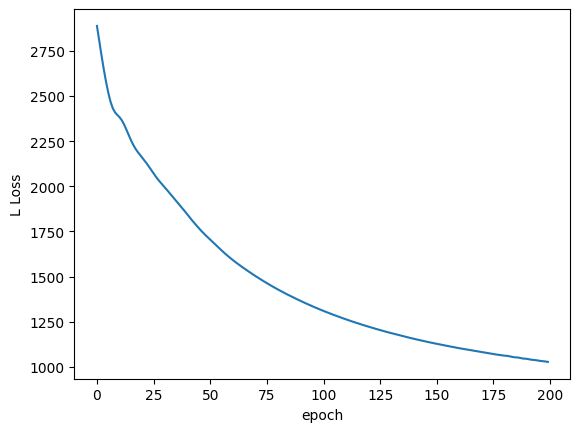

In [28]:
los = [fl.item() for fl in losses ]
plt.plot(range(epochs), los)
plt.ylabel('L Loss')
plt.xlabel('epoch');

## Evaluation Metrics

### Concordance Index

The concordance index is a metric for evaluating the discriminative ability of survival models. This method uses survival times and predicted risk to evaluate the comparative survival prospects for each pair of observations, while taking into account censoring. All combinations of individuals are compared and a pair is deemed concordant if the model predicts a higher risk for the individual that has a shorter event time. If the model predicts a higher risk for the individual that has a longer event time, the pair is discordant. The condcordance index is the ratio of concordant pairs and all pairs. In the case of right censoring, the pair is not counted if the individual with the shorter survival time is censored. A concordance score of 1 is the best possible score and a score of 0.5 is equivalent to random guessing. 

In [29]:
def concordance_index(risk, time, event_status):
  '''
  risk = individual risk for event, output from model
  time = time to event or censor ordered
  event_status = 1 if event, 0 if censor
  '''
  numerator = 0
  denominator = 0
  for j,i in combinations(range(len(time)), 2):
    if time[j] < time[i] and risk[j] > risk[i]:
      numerator += 1*int(event_status[j])
    if time[j] < time[i]:
      denominator += 1*int(event_status[j])
  c = numerator/denominator
  return c

In [30]:
risk_test = model(XTensor_test)
concordance_index(risk = risk_test[:, 0], time = timeTensor_test, event_status = statusTensor_test)

0.8628643510384286

The concordance for this model is 0.86. This is a fairly high score for model discernment.

## Survival Curve and Prediction

To plot a survival curve, we need to select a pattern of covariates. I will sample from the test set.

In [42]:
example_pattern = data_test.sample(random_state=1)
example_pattern.head()

,product_data_storage,csat_score,articles_viewed,smartphone_notifications_viewed,marketing_emails_clicked,social_media_ads_viewed,minutes_customer_support,months_active,churned,product_travel_expense_Free-Trial,...,us_region_Mountain,us_region_New England,us_region_Pacific,us_region_South Atlantic,us_region_West North Central,us_region_West South Central,company_size_10-50,company_size_100-250,company_size_50-100,company_size_self-employed
446,3.199315,-0.99425,0.506248,1.067252,0.895531,-0.675838,-0.35684,3.0,0.0,1,...,0,1,0,0,0,0,0,0,1,0


In [43]:
# standardize
X_example = np.stack([example_pattern[col].values for col in X], axis = 1)
XTensor_example = torch.tensor(X_example, dtype = torch.float)
print(XTensor_example.shape)

torch.Size([1, 25])


In [44]:
risk_example = model(XTensor_example)
print(risk_example)

tensor([[-2.7791,  2.3765]], grad_fn=<CatBackward0>)


In [59]:
risk_example[:,  1].detach().numpy()

array([2.3765419], dtype=float32)

In [70]:
def weibull_survival(time, risk, p):
    risk = risk.detach().numpy()
    p = p.detach().numpy()
    lamb = np.exp(risk)
    survival = np.exp(-1*lamb*pow(time, p))
    return survival

In [71]:
weibull_survival(time = 3., risk = risk_example[:, 0], p = risk_example[:,  1])

array([0.42946637], dtype=float32)

In [54]:
dataset['months_active'].describe()

count    2000.000000
mean        3.879500
std         2.390782
min         0.000000
25%         2.000000
50%         3.000000
75%         5.000000
max        12.000000
Name: months_active, dtype: float64

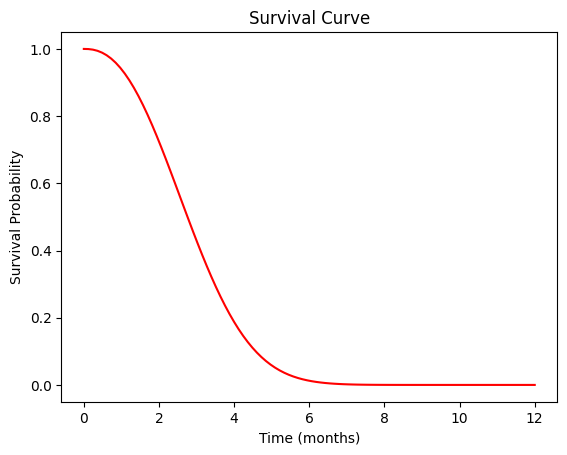

In [78]:
min_time = dataset['months_active'].min()
max_time = dataset['months_active'].max()
t = np.linspace(min_time, max_time, 100)
plt.plot(t, weibull_survival(time = t, risk = risk_example[:, 0], p = risk_example[:,  1]), color='red')
plt.xlabel('Time (months)') 
plt.ylabel('Survival Probability')
plt.title('Survival Curve')
plt.show()